# mcDETECT Tutorial

Authors: Chenyang Yuan, Krupa Patel, Hongshun Shi, Hsiao-Lin V. Wang, Feng Wang, Ronghua Li, Yangping Li, Victor G. Corces, Hailing Shi, Sulagna Das, Jindan Yu, Peng Jin, Bing Yao* and Jian Hu*

### Outline

1. [Installation](#1-installation)
2. [Import Python modules](#2-import-python-modules)
3. [Read in data](#3-read-in-data)
4. [Parameter settings](#4-parameter-settings)
5. [RNA granule detection](#5-rna-granule-detection)
6. [Spatial domain assignment](#6-spatial-domain-assignment)
7. [Granule transcriptome profiling](#7-granule-transcriptome-profiling)
8. [Granule subtyping](#8-granule-subtyping)

### 1. Installation

The detailed installation procedure can be found in [Installation](../README.md/#installation). Here I directly install `mcDETECT` by running:

```bash
python3 -m pip install mcDETECT
```

Check the current version:

In [1]:
import mcDETECT
mcDETECT.__version__

'2.0.3'

### 2. Import Python modules

Compiling this tutorial file needs the following Python packages:

In [28]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scanpy as sc
import SpaGCN as spg
import torch
from collections import defaultdict
from sklearn.cluster import KMeans, MiniBatchKMeans

from mcDETECT.utils import *
from mcDETECT.model import *

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0

You may also need to have `pyarrow` and `fastparquet` installed for reading `.parquet` files.

### 3. Read in data

The toy dataset used in this tutorial is part of the isocortex region from the [Xenium 5K mouse brain data](https://www.10xgenomics.com/datasets/xenium-prime-fresh-frozen-mouse-brain).

`mcDETECT` requires the following input:

* Transcript file: dataframe, records gene identity and 3D spatial coordinates of each mRNA molecule

In [3]:
transcripts = pd.read_parquet("toy_data/transcripts.parquet")

We need to rename some columns of the transcript file to adapt to the input format. The input transcript file should look like:

In [ ]:
transcripts = transcripts[["cell_id", "overlaps_nucleus", "feature_name", "x_location", "y_location", "z_location"]]
transcripts = transcripts.rename(columns = {"feature_name": "target", "x_location": "global_x", "y_location": "global_y", "z_location": "global_z"})
print(transcripts.head().to_string())

              cell_id  overlaps_nucleus target     global_x     global_y   global_z
163006771  fgdhmaei-1                 0   A1cf  5994.734375  2021.468750  15.125000
163006772  UNASSIGNED                 0    A2m  5763.109375  2043.625000  15.781250
163006773  UNASSIGNED                 0    A2m  5951.984375  2085.984375  16.578125
163006774  hieeideh-1                 1   Aatf  5757.593750  2163.453125  17.281250
163006775  fghnlpdi-1                 1   Aatf  5969.406250  2149.406250  17.625000


* Granule markers: user-defined list

In [5]:
syn_genes = ["Snap25", "Camk2a", "Slc17a7", "Cyfip2", "Map2", "Syp", "Syn1", "Slc32a1", "Vamp2", "Mapt", "Gria2", "Gap43", "Tubb3", "Dlg4", "Gria1", "Bsn"]

* (Optional) Negative control markers: user-defined list. If `None`, negative control filtering will be disabled.

In [ ]:
nc_genes = pd.read_csv("toy_data/negative_controls.csv")
nc_genes = list(nc_genes["Gene"])
print(nc_genes[:10])

['Neat1', 'Robo3', 'Sec1', 'Syne4', 'Xist', 'Thpo', 'Spaca6', 'Trmt13', 'Fbxl12', 'Cenpa']


### 4. Parameter settings

Instantiate an object `mc` from `mcDETECT`:

In [7]:
mc = mcDETECT(type = "Xenium", transcripts = transcripts, syn_genes = syn_genes, nc_genes = nc_genes, eps = 1.5,
              minspl = 3, grid_len = 1, cutoff_prob = 0.95, alpha = 5, low_bound = 3, size_thr = 5,
              in_nucleus_thr = (0.5, 0.5), l = 1, rho = 0.2, s = 1, nc_top = 20, nc_thr = 0.1)

Hyperparameters in `mcDETECT`:
* `eps` ($\epsilon$): numeric, searching radius in density-based clustering, default is 1.5 $\mu m$
* `minspl`: integer, min_samples in density-based clustering, default is `None`. Users can manually define `minspl` and thus disable the automatic parameter selection process.
* `grid_len`: numeric, side length of square grids over the tissue region (used in approximating the tissue area), default is 1 $\mu m$
* `cutoff_prob`: numeric, cutoff probability in parameter selection for min_samples, default is 0.95
* `alpha` ($\alpha$): numeric, enhancing factor in parameter selection for min_samples, default is 5
* `low_bound`: integer, lower bound in parameter selection for min_samples, default is 3
* `size_thr`: numeric, threshold for maximum radius of an aggregation, default is 5 $\mu m$
* `in_nucleus_thr`: 2-d tuple, thresholds for low and high in-nucleus ratio, default is (0.5, 0.5)
* `l`: numeric, scaling factor for seaching overlapped spheres, default is 1
* `rho` ($\rho$): numeric, threshold for determining overlaps, default is 0.2
* `s`: numeric, scaling factor for merging overlapped spheres, default is 1
* `nc_top`: integer, number of top negative control genes retained for filtering, default is 20
* `nc_thr`: numeric, threshold for negative control filtering, default is 0.1

Note that we fix `minspl` at 3 due to the fact that individual RNA granules contain low copy numbers ([Tarannum, Renesa, et al.](https://www.biorxiv.org/content/10.1101/2024.07.13.603387v4)).

### 5. RNA granule detection

RNA granule detection is implemented in the `detect()` function:

In [8]:
granules = mc.detect()

1 out of 16 genes processed!
2 out of 16 genes processed!
3 out of 16 genes processed!
4 out of 16 genes processed!
5 out of 16 genes processed!
6 out of 16 genes processed!
7 out of 16 genes processed!
8 out of 16 genes processed!
9 out of 16 genes processed!
10 out of 16 genes processed!
11 out of 16 genes processed!
12 out of 16 genes processed!
13 out of 16 genes processed!
14 out of 16 genes processed!
15 out of 16 genes processed!
16 out of 16 genes processed!
Merging spheres...
Negative control filtering...


The output is a dataframe of RNA granule metadata:

In [10]:
print(granules.head().to_string())

      sphere_x     sphere_y   sphere_z  layer_z  sphere_r  size  comp  in_nucleus    gene
0  5784.544734  2179.629187  16.093963       16  0.888164   4.0   1.0           0  Snap25
1  5796.601562  2120.851562  16.820312       16  1.410129   8.0   5.0           0  Snap25
2  5801.742188  2182.664062  17.367188       17  1.411859   6.0   2.0           0  Snap25
3  5817.137192  2086.775136  15.920899       15  0.458957   3.0   1.0           0  Snap25
4  5818.511953  2053.509849  16.940483       16  1.401331  11.0   5.0           0  Snap25


* `sphere_x`, `sphere_y`, `sphere_z`: 3D spatial coordinates of each identified RNA granule
* `layer_z`: the nearest z-layer of each identified RNA granule, only applicable in iST datasets with discrete z-coordinates, e.g., MERSCOPE and CosMx
* `sphere_r`: radius of each identified RNA granule
* `size`: number of granule mRNAs within each RNA granule
* `comp`: number of granule genes presented in each RNA granule
* `in_nucleus`: proportion of granule mRNAs located within cell nuclei
* `gene`: primary granule marker that defines the associated RNA granule

### 6. Spatial domain assignment

To detect spatial domains, we first need to create a spot-level gene expression data from the transcript file. Here we only retain the top 1,000 highly variable genes and use the `spot_expression()` function to construct such data:

In [ ]:
highly_variable_genes = pd.read_csv("toy_data/highly_variable_genes.csv")
highly_variable_genes = list(highly_variable_genes.iloc[:, 0])

spots = mc.spot_expression(grid_len = 50, genes = highly_variable_genes)

0 out of 1000 genes profiled!
100 out of 1000 genes profiled!
200 out of 1000 genes profiled!
300 out of 1000 genes profiled!
400 out of 1000 genes profiled!
500 out of 1000 genes profiled!
600 out of 1000 genes profiled!
700 out of 1000 genes profiled!
800 out of 1000 genes profiled!
900 out of 1000 genes profiled!


* `grid_len`: numeric, side length of square grids over the tissue region, default is 50 $\mu m$

The output is an anndata object representing the spot-level gene expression data:

In [12]:
spots

AnnData object with n_obs × n_vars = 400 × 1000
    obs: 'spot_id', 'global_x', 'global_y'
    var: 'genes'

Next, we apply a spatial clustering approach, `SpaGCN`, on this anndata object for spatial domain detection. For more details check its [GitHub page](https://github.com/jianhuupenn/SpaGCN/).

In [ ]:
%%capture

# Spot coordinates
x_array = spots.obs["global_x"].tolist()
y_array = spots.obs["global_y"].tolist()

# Adjacency matrix
s = 1
b = 49
adj = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)

# Pre-processing
spots.var_names_make_unique()
spg.prefilter_genes(spots, min_cells = 3)
spg.prefilter_specialgenes(spots)
sc.pp.normalize_total(spots, target_sum = 1e4)
sc.pp.log1p(spots)

# Set hyperparameters
p = 0.5
l = spg.search_l(p, adj, start = 0.01, end = 1000, tol = 0.01, max_run = 100)

n_clusters = 6
r_seed = t_seed = n_seed = 1
res = spg.search_res(spots, adj, l, n_clusters, start = 0.7, step = 0.1, tol = 5e-3, lr = 0.05, max_epochs = 20, r_seed = r_seed, t_seed = t_seed, n_seed = n_seed)

# Run SpaGCN
clf = spg.SpaGCN()
clf.set_l(l)

random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)

clf.train(spots, adj, init_spa = True, init = "louvain", res = res, tol = 5e-3, lr = 0.05, max_epochs = 200)
y_pred, prob = clf.predict()
spots.obs["pred"] = y_pred
spots.obs["pred"] = spots.obs["pred"].astype("category")

adj_2d = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)
refined_pred = spg.refine(sample_id = spots.obs.index.tolist(), pred = spots.obs["pred"].tolist(), dis = adj_2d, shape = "square")
spots.obs["refined_pred"] = refined_pred
spots.obs["refined_pred"] = spots.obs["refined_pred"].astype("category")

Spot-level spatial domain assignment:

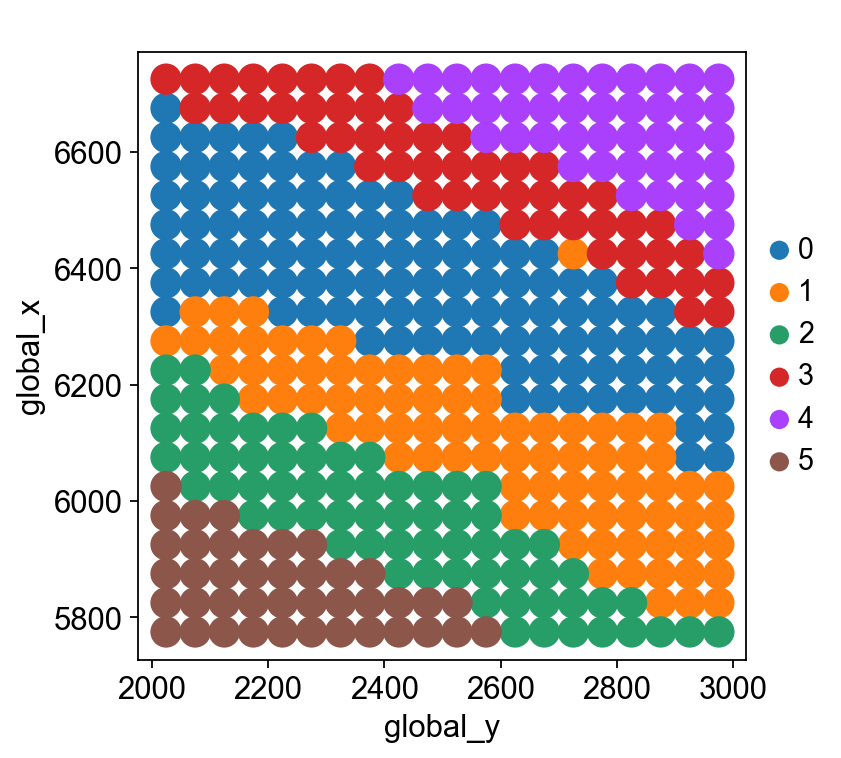

In [ ]:
sc.set_figure_params(scanpy = True, figsize = (5, 5))
ax = sc.pl.scatter(spots, alpha = 1, x = "global_y", y = "global_x", color = "refined_pred", size = 800, title = " ", show = False)
ax.grid(False)
ax.set_aspect("equal", "box")
plt.savefig("tutorial_files/spatial_domain.png", dpi = 120)
plt.show()

We can replace the spatial domain labels with meaningful brain region labels, i.e., isocortex layers:

In [ ]:
area_dict = {"Others": [4],
             "Layer I": [3],
             "Layer II/III": [0],
             "Layer IV": [1],
             "Layer V": [2],
             "Layer VI": [5]}

spots.obs["brain_area"] = np.nan
for i in area_dict.keys():
    ind = pd.Series(spots.obs["refined_pred"]).isin(area_dict[i])
    spots.obs.loc[ind, "brain_area"] = i

The assigned brain region label for each spot is propagated to all granules within it. The `closest()` function is designed to identify the element in a list that has the smallest distance to the query item.

In [ ]:
labels_df = pd.DataFrame({"global_x": spots.obs["global_x"], "global_y": spots.obs["global_y"], "brain_area": spots.obs["brain_area"]})
x_grid, y_grid = list(np.unique(labels_df["global_x"])), list(np.unique(labels_df["global_y"]))

granules["brain_area"] = np.nan
for i in range(granules.shape[0]):
    closest_x = closest(x_grid, granules["sphere_x"].iloc[i])
    closest_y = closest(y_grid, granules["sphere_y"].iloc[i])
    target_label = labels_df[(labels_df["global_x"] == closest_x) & (labels_df["global_y"] == closest_y)]
    granules["brain_area"].iloc[i] = target_label["brain_area"][0]

The resulting spatial distribution of all identified RNA granules, colored by brain region:

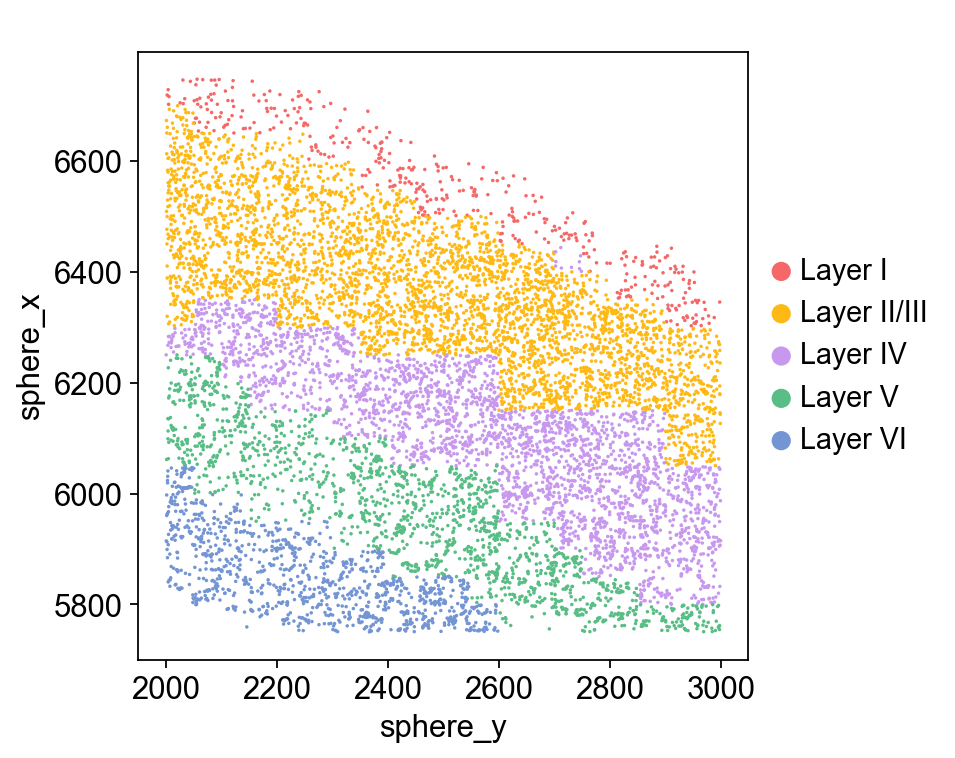

In [ ]:
granule_adata = anndata.AnnData(X = np.zeros(granules.shape), obs = granules)
granule_adata.obs["brain_area"] = pd.Categorical(granule_adata.obs["brain_area"], categories = ["Layer I", "Layer II/III", "Layer IV", "Layer V", "Layer VI"], ordered = True)

color_map = ["#F56867", "#FEB915", "#C798EE", "#59BE86", "#7495D3"]
ax = sc.pl.scatter(granule_adata, alpha = 1, x = "sphere_y", y = "sphere_x", color = "brain_area", palette = color_map, size = 10, title = " ", show = False)
ax.grid(False)
ax.set_aspect("equal", "box")
plt.savefig("tutorial_files/granules.png", dpi = 120)
plt.show()

### 7. Granule transcriptome profiling

Granule transcriptome profiling is implemented in the `profile()` function:

In [56]:
gnl_adata = mc.profile(granules)

The output is an anndata object representing the spatial transcriptome profile of all identified RNA granules:

In [57]:
gnl_adata

AnnData object with n_obs × n_vars = 9991 × 5006
    obs: 'global_x', 'global_y', 'global_z', 'layer_z', 'sphere_r', 'size', 'comp', 'in_nucleus', 'gene', 'brain_area', 'synapse_id'
    var: 'genes'

Basic normalization and log-transformation:

In [58]:
sc.pp.normalize_total(gnl_adata, target_sum=1e4)
sc.pp.log1p(gnl_adata)

### 8. Granule subtyping

We can classify the identified RNA granules into dinstinct subtypes, e.g., enriched pre-synaptic genes and post-synaptic genes, based on their transcriptome profile. Here we use a list of synaptic, dendritic, and axonal markers for granule subtyping:

In [63]:
genes_syn_pre = ["Bsn", "Gap43", "Nrxn1", "Slc17a6", "Slc17a7", "Slc32a1", "Snap25", "Stx1a", "Syn1", "Syp", "Syt1", "Vamp2", "Cplx2"]
genes_syn_post = ["Camk2a", "Dlg3", "Dlg4", "Gphn", "Gria1", "Gria2", "Homer1", "Homer2", "Nlgn1", "Nlgn2", "Nlgn3", "Shank1", "Shank3"]
genes_axon = ["Ank3", "Nav1", "Sptnb4", "Nfasc", "Mapt", "Tubb3"]
genes_dendrite = ["Actb", "Cyfip2", "Ddn", "Dlg4", "Map1a", "Map2"]

ref_genes = list(set(genes_syn_pre + genes_syn_post + genes_axon + genes_dendrite))
ref_genes = [i for i in ref_genes if i in gnl_adata.var_names]

gnl_adata_subset = gnl_adata[:, ref_genes].copy()
gnl_adata_subset

AnnData object with n_obs × n_vars = 9991 × 24
    obs: 'global_x', 'global_y', 'global_z', 'layer_z', 'sphere_r', 'size', 'comp', 'in_nucleus', 'gene', 'brain_area', 'synapse_id'
    var: 'genes'
    uns: 'log1p'

K-Means clustering on the granules based on the enrichment of these markers:

In [64]:
data = gnl_adata_subset.X
if not isinstance(data, np.ndarray):
    data = data.toarray()

n_clusters = 8
kmeans = MiniBatchKMeans(n_clusters = n_clusters, batch_size = 500, random_state = 0)
kmeans.fit(data)
gnl_adata.obs["granule_subtype_kmeans"] = kmeans.labels_.astype(str)

desired_order = [f"{i}" for i in range(n_clusters)]
gnl_adata.obs["granule_subtype_kmeans"] = pd.Categorical(gnl_adata.obs["granule_subtype_kmeans"], categories=desired_order, ordered=True)

Examine the enrichment of these markers in each resulting clusters:

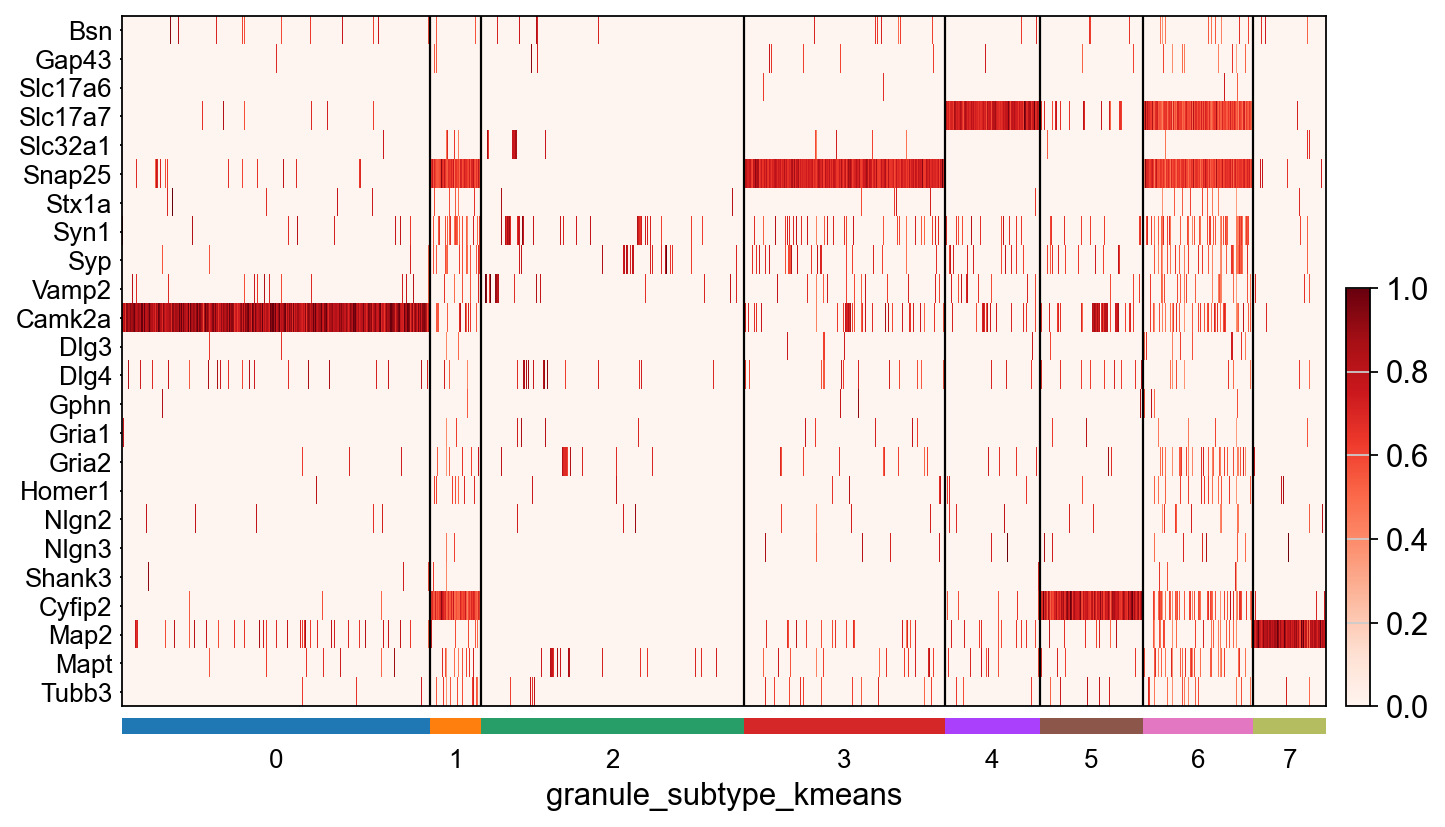

In [66]:
ref_genes_sorted = ["Bsn", "Gap43", "Slc17a6", "Slc17a7", "Slc32a1", "Snap25", "Stx1a", "Syn1", "Syp", "Vamp2", "Camk2a", "Dlg3", "Dlg4", "Gphn", "Gria1", "Gria2", "Homer1", "Nlgn2", "Nlgn3", "Shank3", "Cyfip2", "Map2", "Mapt", "Tubb3"]
gnl_adata_subset.obs["granule_subtype_kmeans"] = gnl_adata.obs["granule_subtype_kmeans"].copy()

ax = sc.pl.heatmap(gnl_adata_subset, var_names = ref_genes_sorted, groupby = "granule_subtype_kmeans", cmap = "Reds", standard_scale = "var", dendrogram = False, swap_axes = True, show = False, figsize = (10, 6))
plt.show()

Assign each cluster as representing enriched for pre-synaptic, post-synaptic, dendritic, or mixed signals:

In [68]:
pre_list = ["3", "4", "6"]
post_list = ["0"]
den_list = ["5", "7"]
axon_list = []
mixed_list = ["1"]
others_list = ["2"]

subtype_dict = {"pre-syn": pre_list, "post-syn": post_list, "dendrites": den_list, "axons": axon_list, "mixed": mixed_list, "others": others_list}
gnl_adata.obs["granule_subtype"] = np.nan
for i in subtype_dict.keys():
    ind = pd.Series(gnl_adata.obs["granule_subtype_kmeans"]).isin(subtype_dict[i])
    gnl_adata.obs.loc[ind, "granule_subtype"] = i
gnl_adata.obs["granule_subtype"] = pd.Categorical(gnl_adata.obs["granule_subtype"], categories=["pre-syn", "post-syn", "dendrites", "axons", "mixed", "others"], ordered=True)
gnl_adata.obs["granule_subtype"] = gnl_adata.obs["granule_subtype"].cat.remove_unused_categories()

Spatial distribution of the identified granule_subtypes:

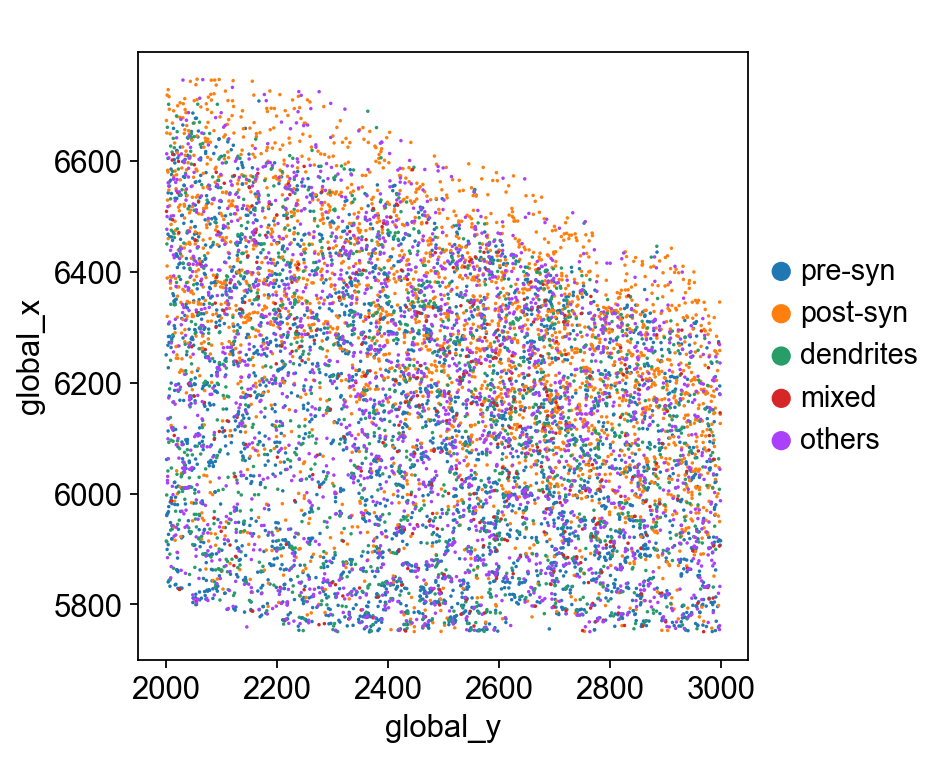

In [71]:
ax = sc.pl.scatter(gnl_adata, alpha = 1, x = "global_y", y = "global_x", color = "granule_subtype", size = 10, title = " ", show = False)
ax.grid(False)
ax.set_aspect("equal", "box")
plt.savefig("tutorial_files/granule_subtypes.png", dpi = 120)
plt.show()